In [2]:
import random
import pickle
import json
import joblib
import numpy as np
from lime import lime_tabular
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from models.lstm import LSTMModel

In [3]:
# Initialize model
input_size = 4  # Number of selected features
hidden_size = 50
num_layers = 2
output_size = 1
dropout = 0.2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout).to(device)
model.load_state_dict(torch.load('./trained_models/best_model.pth'))
model.eval()

Using device: cuda


LSTMModel(
  (lstm): LSTM(4, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [4]:
file_path = 'data/household_power_consumption.txt'
data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']}, 
                   infer_datetime_format=True, low_memory=False, na_values=['?'])

# Fill missing values
data.fillna(data.mean(), inplace=True)

# Select relevant features
selected_features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']
data_selected = data[selected_features]

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_selected.values)

# Create sequences
sequence_length = 60  # e.g., past 60 minutes
sequences = []
targets = []
for i in range(len(data_scaled) - sequence_length):
    sequences.append(data_scaled[i:i + sequence_length])
    targets.append(data_scaled[i + sequence_length, 0])

sequences = np.array(sequences)
targets = np.array(targets)

# Split into train and eval sets
train_size = int(len(sequences) * 0.8)
train_sequences, eval_sequences = sequences[:train_size], sequences[train_size:]
train_targets, eval_targets = targets[:train_size], targets[train_size:]

/tmp/ipykernel_10408/2170405519.py:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},
/tmp/ipykernel_10408/2170405519.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},
/tmp/ipykernel_10408/2170405519.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv(file_path, sep=';', parse_dates={'datetime': ['Date', 'Time']},


## LIME

In [5]:
explainer_path = './trained_explainer/lime_explainer_config.json'

if os.path.exists(explainer_path) == False:
    # Extract the explainer configuration
    explainer_config = {
        "training_data": sequences.reshape(-1, sequence_length * input_size).tolist(),
        "feature_names": [f"{feature}_{i}" for i in range(sequence_length) for feature in selected_features],
        "class_names": ['Global_active_power'],
        "mode": 'regression'
    }
    
    # Ensure the directory exists
    os.makedirs('./trained_explainer', exist_ok=True)
    
    # Save the explainer configuration using JSON
    with open('./trained_explainer/lime_explainer_config.json', 'w') as file:
        json.dump(explainer_config, file)
else:
    print('skip')

skip


In [22]:
# Load the explainer configuration using JSON
with open('./trained_explainer/lime_explainer_config.json', 'r') as file:
    explainer_config = json.load(file)

# Re-create the explainer from the configuration
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(explainer_config["training_data"]),
    feature_names=explainer_config["feature_names"],
    class_names=explainer_config["class_names"],
    mode=explainer_config["mode"]
)

# Define the prediction function
def predict_fn(input_data):
    input_data = input_data.reshape(-1, sequence_length, input_size)
    model.eval()
    input_data = torch.tensor(input_data, dtype=torch.float32).to(device)  # Move data to GPU
    with torch.no_grad():
        outputs = model(input_data)
    return outputs.cpu().numpy()

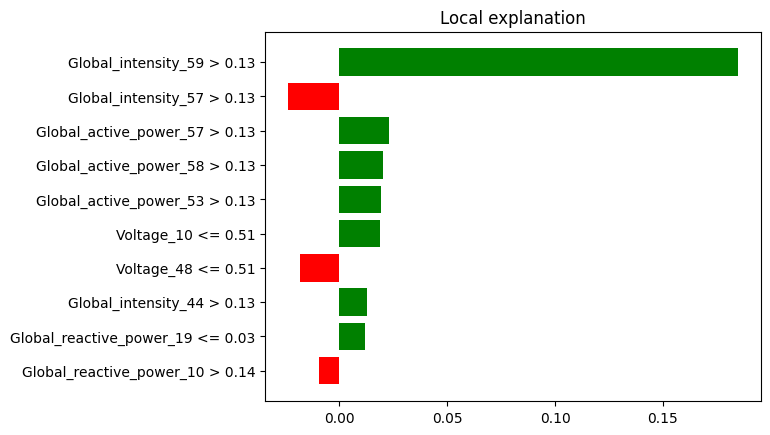

In [20]:
## 하나의 데이터 샘플에 대한 중요 feature 찾기 

# Explain a specific data sample
specific_data_point = sequences[0].reshape(-1)  # Flatten the first sequence for explanation

# Generate explanation for the specific data point
specific_explanation = explainer.explain_instance(specific_data_point, predict_fn, num_samples=1000, num_features=10)

# Show the explanation
specific_explanation.show_in_notebook(show_table=True)

# Plot the explanation
specific_explanation.as_pyplot_figure()
plt.savefig('./results/lime_one_sample.png')  # Save the plot as an image file
plt.show()

Feature Name: 'Global_intensity_59'

Global_intensity는 원래 데이터셋에서의 feature 이름입니다.
_59는 시퀀스에서의 시간 단계(index)를 나타냅니다. 즉, Global_intensity의 59번째 시간 단계 값을 의미합니다.
값의 범위: ' > 0.13' 

*** 주요 feature에 대한 원래 데이터 값을 가져와서 보여주면 좋을 것 같음 (59번째 값, 0.13에 대한 기준값의 원래 값 매핑)

이 부분은 해당 시간 단계에서 Global_intensity의 값이 0.13보다 크다는 것을 의미합니다.
따라서, "'Global_intensity_59 > 0.13'"은 59번째 시간 단계에서 Global_intensity 값이 0.13보다 큰지 여부가 예측에 중요한 영향을 미쳤음을 나타냅니다.

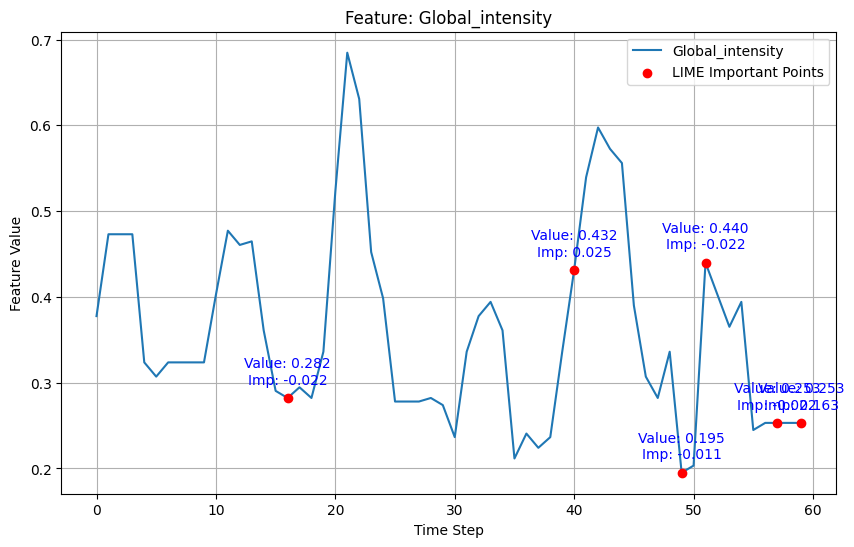


Feature: Global_intensity - Detailed Information
Time Step: 59, Feature Value: 0.253, Importance: 0.163
Time Step: 40, Feature Value: 0.432, Importance: 0.025
Time Step: 51, Feature Value: 0.440, Importance: -0.022
Time Step: 57, Feature Value: 0.253, Importance: -0.022
Time Step: 16, Feature Value: 0.282, Importance: -0.022
Time Step: 49, Feature Value: 0.195, Importance: -0.011


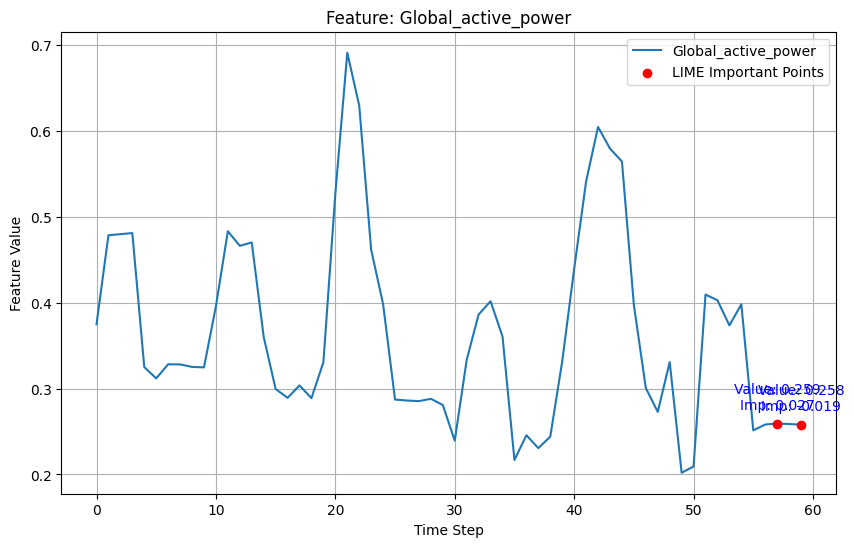


Feature: Global_active_power - Detailed Information
Time Step: 57, Feature Value: 0.259, Importance: 0.027
Time Step: 59, Feature Value: 0.258, Importance: -0.019


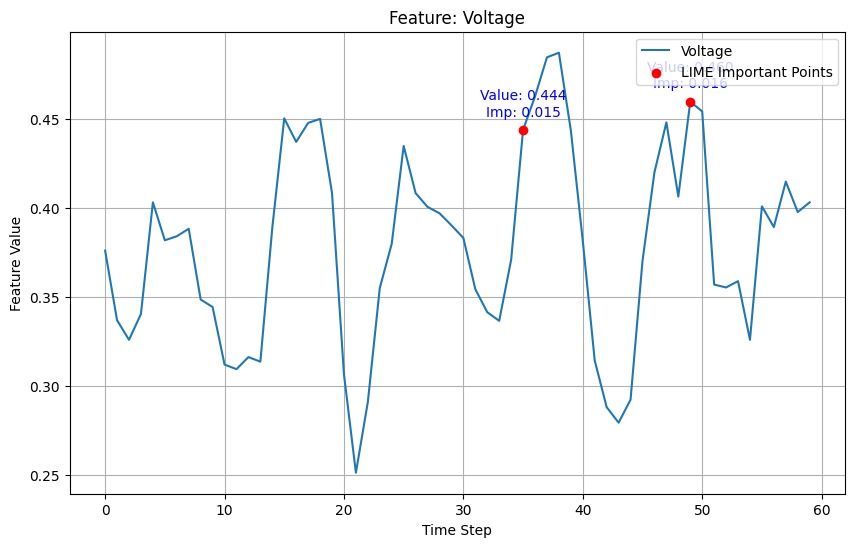


Feature: Voltage - Detailed Information
Time Step: 49, Feature Value: 0.460, Importance: 0.016
Time Step: 35, Feature Value: 0.444, Importance: 0.015


In [21]:
# Explain a specific data sample
specific_data_point = sequences[0].reshape(-1)  # Flatten the first sequence for explanation
specific_explanation = explainer.explain_instance(specific_data_point, predict_fn, num_samples=1000, num_features=10)

# Extract the important features and their threshold values
important_features = specific_explanation.as_list()

# Dictionary to group features by their base name
feature_dict = {}

for feature_description, importance in important_features:
    if ' > ' in feature_description:
        feature_name, _ = feature_description.split(' > ')
    elif ' <= ' in feature_description:
        feature_name, _ = feature_description.split(' <= ')
    else:
        feature_name = feature_description  # Just the feature name without condition
    
    feature_index = explainer.feature_names.index(feature_name)
    actual_feature, time_step = feature_name.rsplit('_', 1)
    time_step = int(time_step)

    # Add the feature to the dictionary
    if actual_feature not in feature_dict:
        feature_dict[actual_feature] = []
    
    feature_dict[actual_feature].append((time_step, sequences[0][time_step, selected_features.index(actual_feature)], importance))

# Plot each feature with its important time steps
for actual_feature, values in feature_dict.items():
    plt.figure(figsize=(10, 6))
    time_steps = [v[0] for v in values]
    actual_values = [v[1] for v in values]
    importances = [v[2] for v in values]

    plt.plot(range(sequence_length), sequences[0][:, selected_features.index(actual_feature)], label=f'{actual_feature}')
    plt.scatter(time_steps, actual_values, color='red', zorder=5, label='LIME Important Points')

    # Annotate the points with their importance and actual value
    for i, (x, y) in enumerate(zip(time_steps, actual_values)):
        plt.annotate(f'Value: {y:.3f}\nImp: {importances[i]:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', color='blue')

    plt.xlabel('Time Step')
    plt.ylabel('Feature Value')
    plt.title(f'Feature: {actual_feature}')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    # Print the detailed information about the important points
    print(f'\nFeature: {actual_feature} - Detailed Information')
    for time_step, value, importance in values:
        print(f'Time Step: {time_step}, Feature Value: {value:.3f}, Importance: {importance:.3f}')
        

In [ ]:

네, LIME에서 선택된 주요 feature가 반드시 그래프의 최대값이나 최소값에 해당하지 않는 것은 정상적인 현상입니다. LIME의 작동 방식 때문에 이러한 결과가 나올 수 있습니다.

이유: LIME의 작동 방식
로컬 설명:

LIME은 전체 모델을 글로벌하게 이해하려는 것이 아니라, 특정 데이터 포인트(또는 데이터 샘플)에 대해 모델이 왜 그런 예측을 했는지 로컬하게 설명하려는 기법입니다.
즉, LIME은 특정 데이터 포인트 주변에서 모델이 어떻게 행동하는지를 설명하기 위해, 해당 데이터 포인트 주변의 데이터에 기반한 선형 모델을 학습합니다.
데이터 포인트의 중요도:

LIME이 특정 feature를 중요한 것으로 간주할 때, 이 feature가 특정 예측에 얼마나 기여했는지에 따라 평가됩니다. 이때 중요한 것은 모델의 예측 변화에 대한 기여도이지, 해당 feature 값 자체의 크기나 극단적인 값(maximum/minimum)이 아닙니다.
예를 들어, 특정 feature 값이 높거나 낮지 않더라도, 그 값이 모델의 예측에 중요한 기여를 했다고 판단되면, LIME은 그 feature를 주요 feature로 선택할 수 있습니다.
기여도의 측정:

LIME은 각 feature가 모델의 예측에 얼마나 기여했는지를 측정합니다. 예를 들어, 어떤 feature가 중간 값이라도, 모델이 이 값을 기준으로 중요한 결정을 내렸다면, LIME은 그 feature를 주요 feature로 간주할 수 있습니다.
예시: LSTM 기반 전력 수요 예측 모델
예를 들어, LSTM 기반 전력 수요 예측 모델이 있다고 가정해 봅시다. 이 모델이 특정 시점에서 전력 수요를 예측할 때, "Global_active_power"라는 feature가 중요한 역할을 했다고 합시다. 이때 LIME이 이 feature를 주요 feature로 선택할 수 있지만, 이 feature의 값이 꼭 최대값이나 최소값일 필요는 없습니다.

모델의 의사 결정 방식:
모델은 "Global_active_power"의 값이 높을 때만 전력 수요를 예측에 반영하는 것이 아니라, 그 값이 특정 구간에 있을 때 더 중요한 역할을 할 수 있습니다.
이 경우, LIME은 그 특정 구간의 값을 중요한 것으로 간주할 수 있습니다.
결론
LIME에서 선택된 주요 feature가 그래프의 최대값이나 최소값에 해당하지 않는 것은 LIME의 로컬 설명 방식 때문입니다. LIME은 특정 데이터 포인트 주변에서 모델의 예측에 중요한 역할을 한 feature를 강조하는데, 이때 그 feature의 값 자체가 극단적이지 않더라도 모델의 예측에 중요한 영향을 미쳤다면, 그 feature가 주요 feature로 선택될 수 있습니다.

이러한 현상은 LIME이 모델 예측에 대한 직관적인 설명을 제공하면서도, 반드시 극단적인 값만을 강조하지 않고, 모델이 어떻게 의사 결정을 했는지를 설명하는 방식으로 작동하기 때문에 발생합니다.

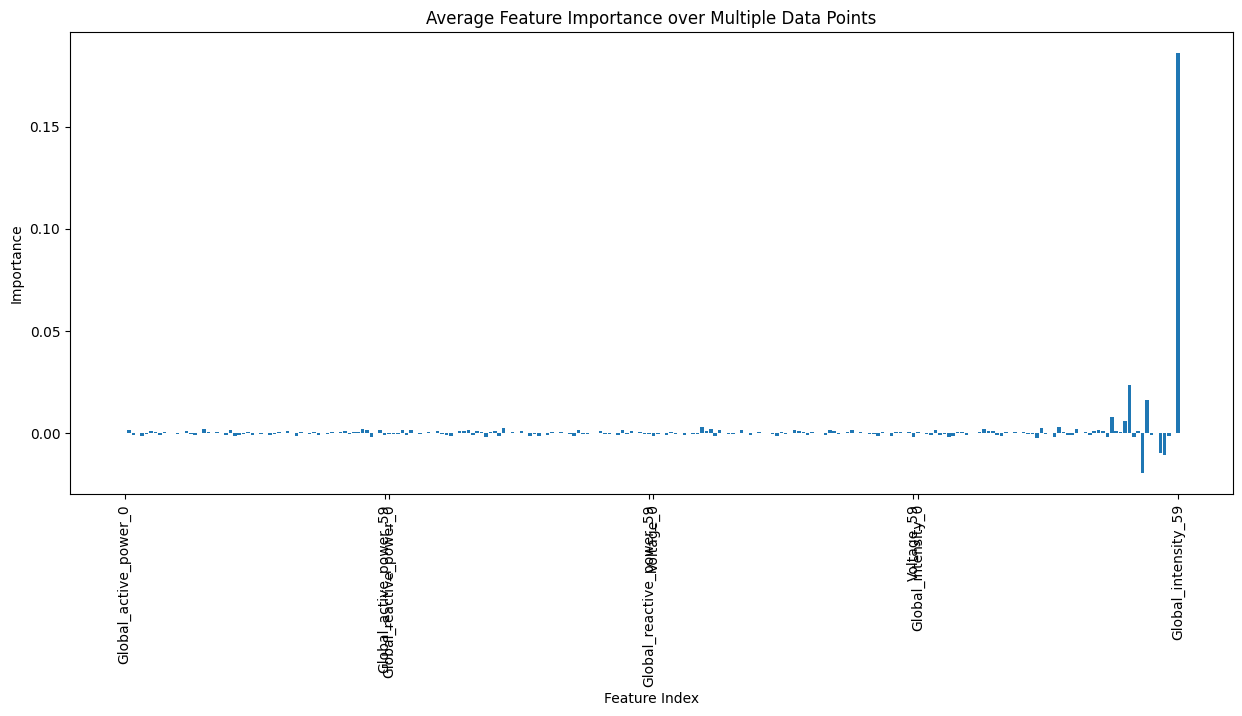

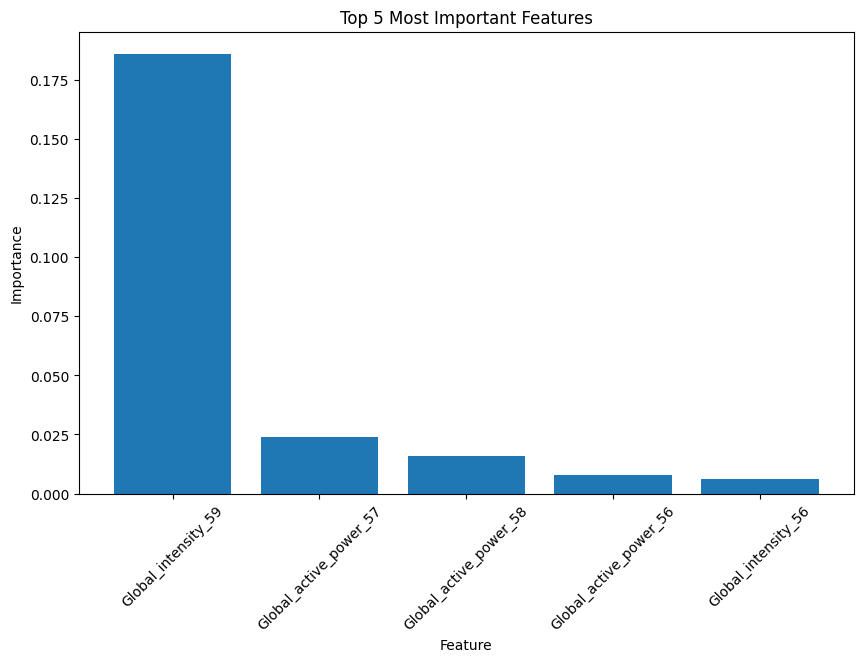

Top 5 Most Important Features:
Global_intensity_59: 0.18599836771166994
Global_active_power_57: 0.023715629512018346
Global_active_power_58: 0.016035354394318982
Global_active_power_56: 0.007768702582283983
Global_intensity_56: 0.006002814728335887


In [14]:
# Generate explanations for multiple data points
num_data_points = 100  # Number of data points to explain
feature_importances = np.zeros(sequence_length * input_size)

for i in range(num_data_points):
    data_point = sequences[i].reshape(-1)  # Flatten the sequence
    explanation = explainer.explain_instance(data_point, predict_fn, num_samples=1000, 
                                             num_features=sequence_length * input_size)
    importances = explanation.as_map()[1]

    for feature_index, importance in importances:
        feature_importances[feature_index] += importance

# Average feature importances
feature_importances /= num_data_points

# Create x-axis labels for start and end of each feature
feature_labels = []
for i in range(sequence_length):
    for feature in selected_features:
        feature_labels.append(f"{feature}_{i}")

# Plot the feature importances with simplified x-axis labels
plt.figure(figsize=(15, 6))
plt.bar(range(sequence_length * input_size), feature_importances)

# Setting x-ticks
xticks_positions = []
xticks_labels = []
for i, feature in enumerate(selected_features):
    xticks_positions.append(i * sequence_length)
    xticks_labels.append(f"{feature}_0")
    xticks_positions.append((i + 1) * sequence_length - 1)
    xticks_labels.append(f"{feature}_{sequence_length - 1}")

plt.xticks(ticks=xticks_positions, labels=xticks_labels, rotation=90)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Average Feature Importance over Multiple Data Points')
plt.savefig('./results/lime_100_samples_all_features.png')  # Save the plot as an image file
plt.show()

# Get the top 5 most important features
top_features_indices = feature_importances.argsort()[-5:][::-1]
top_features = [(feature_labels[i], feature_importances[i]) for i in top_features_indices]

# Plot the top 5 most important features
plt.figure(figsize=(10, 6))
plt.bar([f[0] for f in top_features], [f[1] for f in top_features])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 5 Most Important Features')
plt.xticks(rotation=45)
plt.savefig('./results/lime_100_samples_top5.png')  # Save the plot as an image file
plt.show()

# Print the top 5 most important features for reference
print("Top 5 Most Important Features:")
for feature, importance in top_features:
    print(f"{feature}: {importance}")

In [36]:
len(eval_sequences)

415040

In [ ]:
# Split the data into train and eval sets
train_sequences, eval_sequences, train_targets, eval_targets = train_test_split(sequences, targets, test_size=0.2, random_state=42)

# Generate explanations for evaluation data points
num_eval_data_points = len(eval_sequences)  # Number of evaluation data points to explain
feature_importances = np.zeros(sequence_length * input_size)

for i in range(num_eval_data_points):
    data_point = eval_sequences[i].reshape(-1)  # Flatten the sequence
    explanation = explainer.explain_instance(data_point, predict_fn, num_samples=1000, num_features=sequence_length * input_size)
    importances = explanation.as_map()[1]

    for feature_index, importance in importances:
        feature_importances[feature_index] += importance

# Average feature importances
feature_importances /= num_eval_data_points

# Create x-axis labels for start and end of each feature
feature_labels = []
for i in range(sequence_length):
    for feature in selected_features:
        feature_labels.append(f"{feature}_{i}")

# Plot the feature importances with simplified x-axis labels
plt.figure(figsize=(15, 6))
plt.bar(range(sequence_length * input_size), feature_importances)

# Setting x-ticks
xticks_positions = []
xticks_labels = []
for i, feature in enumerate(selected_features):
    xticks_positions.append(i * sequence_length)
    xticks_labels.append(f"{feature}_0")
    xticks_positions.append((i + 1) * sequence_length - 1)
    xticks_labels.append(f"{feature}_{sequence_length - 1}")

plt.xticks(ticks=xticks_positions, labels=xticks_labels, rotation=90)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Average Feature Importance over Evaluation Data Points')
plt.savefig('./results/lime_evals_all_features.png')  # Save the plot as an image file
plt.show()

# Get the top 5 most important features
top_features_indices = feature_importances.argsort()[-5:][::-1]
top_features = [(feature_labels[i], feature_importances[i]) for i in top_features_indices]

# Plot the top 5 most important features
plt.figure(figsize=(10, 6))
plt.bar([f[0] for f in top_features], [f[1] for f in top_features])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 5 Most Important Features in Evaluation Data')
plt.xticks(rotation=45)
plt.savefig('./results/lime_evals_top5.png')  # Save the plot as an image file
plt.show()

# Print the top 5 most important features for reference
print("Top 5 Most Important Features:")
for feature, importance in top_features:
    print(f"{feature}: {importance}")